[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


    Real Prices  Predicted Prices Real Direction Predicted Direction  \
0    173.500000        177.104473              ↓                   ↓   
1    171.770004        173.289644              ↓                   ↓   
2    173.559998        171.346852              ↑                   ↓   
3    173.750000        172.826565              ↑                   ↑   
4    172.570007        173.636102              ↓                   ↑   
5    172.070007        172.469144              ↓                   ↓   
6    172.070007        172.228553              ↓                   ↓   
7    172.690002        172.004157              ↑                   ↓   
8    175.050003        172.543870              ↑                   ↑   
9    175.160004        174.711580              ↑                   ↑   
10   174.199997        173.910575              ↓                   ↓   
11   171.559998        174.117246              ↓                   ↑   
12   171.839996        170.830994              ↑                

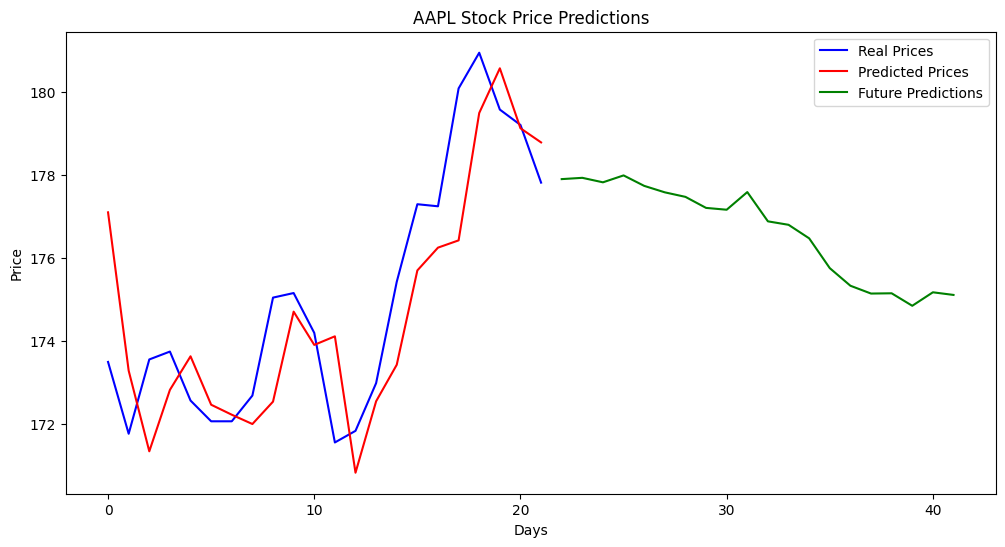

In [2]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Descargamos los datos históricos
data = yf.download('AAPL', start='2020-01-01', end='2023-06-08')

if data.empty:
    raise ValueError("No se pudieron descargar los datos. Verifica la conexión a Internet o el ticker de la acción.")

# Preprocesamiento y escalamiento
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Preparamos los datos para regresión lineal
prediction_days = 60
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Crear el modelo de regresión lineal
model = LinearRegression()
x_train_reshaped = x_train.reshape(x_train.shape[0], x_train.shape[1])
model.fit(x_train_reshaped, y_train)

# Predicción
test_start = '2023-05-08'
test_end = '2023-06-08'
test_data = yf.download('AAPL', start=test_start, end=test_end)
if test_data.empty:
    raise ValueError("No se pudieron descargar los datos de prueba. Verifica la conexión a Internet o el ticker de la acción.")

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test_reshaped = x_test.reshape(x_test.shape[0], x_test.shape[1])

predicted_prices = model.predict(x_test_reshaped)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# Crear un DataFrame para comparar los precios reales y los predichos
df = pd.DataFrame(data={'Real Prices': actual_prices, 'Predicted Prices': predicted_prices.flatten()})

# Calcular las direcciones (up o down)
df['Real Direction'] = df['Real Prices'].diff().apply(lambda x: '↑' if x > 0 else '↓')
df['Predicted Direction'] = df['Predicted Prices'].diff().apply(lambda x: '↑' if x > 0 else '↓')

# Verificar si las direcciones coinciden
df['Direction Match'] = df.apply(lambda row: '✓' if row['Real Direction'] == row['Predicted Direction'] else 'x', axis=1)

print(df)

# Predicción para los próximos 20 días
future_days = 20
x_future = model_inputs[-prediction_days:].reshape(1, prediction_days)
predictions_future = []

for _ in range(future_days):
    prediction = model.predict(x_future)
    predictions_future.append(prediction[0])
    x_future = np.append(x_future[:, 1:], prediction.reshape(-1, 1), axis=1)

# Desescalar los valores predichos
predictions_future = scaler.inverse_transform(np.array(predictions_future).reshape(-1, 1))

print("\nPredicciones para los próximos 20 días:")
print(predictions_future)

# Graficar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(range(len(df)), df['Real Prices'], color='blue', label='Real Prices')
plt.plot(range(len(df)), df['Predicted Prices'], color='red', label='Predicted Prices')
plt.plot(range(len(df), len(df) + future_days), predictions_future, color='green', label='Future Predictions')
plt.title('AAPL Stock Price Predictions')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
